<a href="https://colab.research.google.com/github/theresiasns/capstone/blob/main/Copy_of_Disease_Crop_Detection_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!ppip install --upgrade tensorflow

/bin/bash: ppip: command not found


In [4]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.9/488.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 34.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [5]:
import numpy as np
import os, glob
import seaborn as sns
import pandas as pd
import pickle
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report
from keras.models import Sequential

In [6]:
from google.colab import drive
import os

drive.mount("/content/drive/")

Mounted at /content/drive/


In [7]:
file_path = '/content/drive/MyDrive/agri'

In [8]:
name_class = os.listdir(file_path)
name_class

['Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Apple___Apple_scab',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___healthy',
 'Peach___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Peach___Bacterial_spot',
 'Grape___Esca_(Black_Measles)',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Squash___Powdery_mildew',
 'Tomato_Early_blight',
 'Tomato_Bacterial_spot',
 'Potato___Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Potato___healthy',
 'Potato___Early_blight',
 'Pepper__bell___healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Leaf_Mol

In [9]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [10]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

In [11]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 28899 validated image filenames belonging to 38 classes.
Found 28899 validated image filenames belonging to 38 classes.
Found 9633 validated image filenames belonging to 38 classes.


In [14]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(38, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [22]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
904/904 [==============================] - 7293s 8s/step - loss: 0.6708 - accuracy: 0.7852 - val_loss: 0.3047 - val_accuracy: 0.8967
Epoch 2/5
904/904 [==============================] - 263s 291ms/step - loss: 0.3055 - accuracy: 0.8936 - val_loss: 0.2513 - val_accuracy: 0.9071
Epoch 3/5
904/904 [==============================] - 263s 291ms/step - loss: 0.2163 - accuracy: 0.9237 - val_loss: 0.1307 - val_accuracy: 0.9550
Epoch 4/5
904/904 [==============================] - 277s 307ms/step - loss: 0.1752 - accuracy: 0.9382 - val_loss: 0.1059 - val_accuracy: 0.9630
Epoch 5/5
904/904 [==============================] - 262s 290ms/step - loss: 0.1389 - accuracy: 0.9515 - val_loss: 0.1439 - val_accuracy: 0.9489


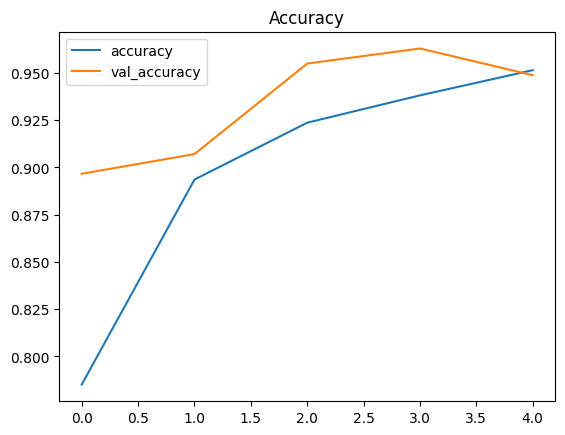

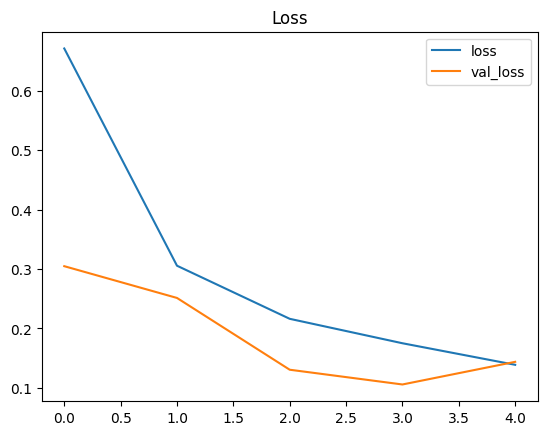

In [23]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [60]:
#accuracy = model.evaluate(test_gen, verbose=0)

#print("Accuracy: {:.2f}%".format(accuracy[1] * 100))

In [25]:
import os
model.save_weights("/content/drive/MyDrive/agri/models1_weights.h5")
model.save("/content/drive/MyDrive/agri/models1_saved.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
export = '/content/drive/MyDrive/agri'
tf.saved_model.save(model,export)

In [27]:
import tensorflow as tf

# Select mode of optimization
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model(export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert();


In [29]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

48138708

In [30]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

302/302 [==============================] - 1766s 6s/step


In [31]:
y_test = list(test.Label)


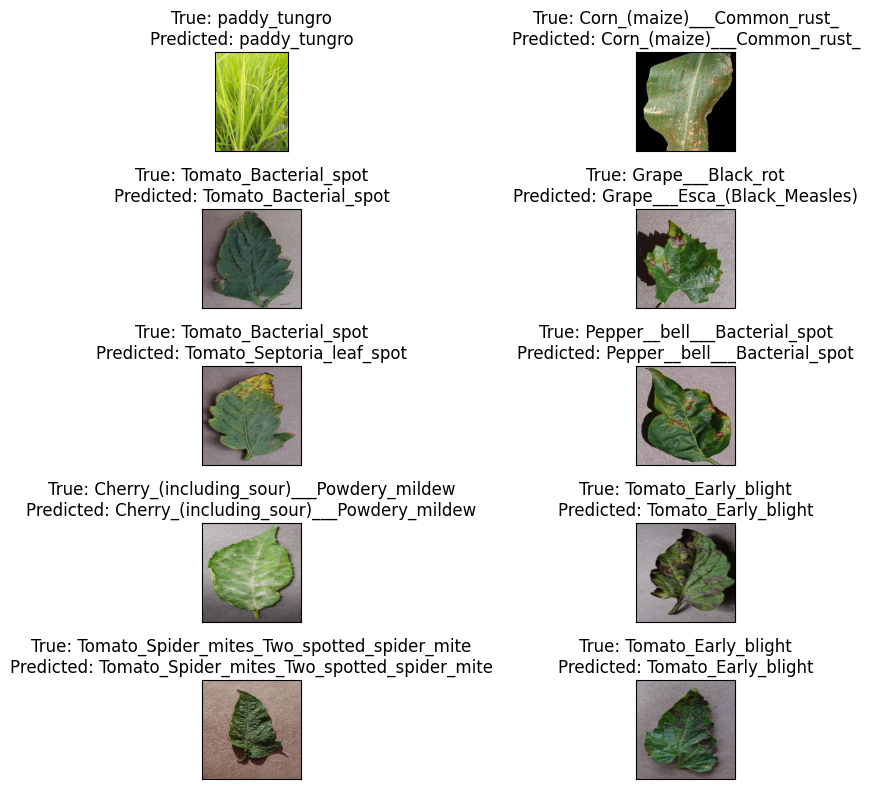

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [58]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

images=files.upload()

print(images)

for i in images:
  print()
 # predicting images
  path = '/content/' + i
  img = load_img(path, target_size=(100,100))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=1)
  predicted_label = name_class[pred[0]]

  print("Predicted Label:", predicted_label)
  print(path)
  #print("Prediction Scores:", classes)

Saving 0db71c1d-93d7-4481-b0d0-b73f995131a9___FREC_Scab 2976.JPG to 0db71c1d-93d7-4481-b0d0-b73f995131a9___FREC_Scab 2976.JPG
{'0db71c1d-93d7-4481-b0d0-b73f995131a9___FREC_Scab 2976.JPG': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvw